In [457]:
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

In [458]:
class Regression:
    
    def __init__(self, feat_dims=0):
        # alpha is weight decay hyperparameter
        
        self.learning_rate =  0.000001
        self.epochs = 500
        self.batch_size = 100
        
        self.feat_dims = feat_dims
        self.output_classes = 1
        
        # create weights array/matrix size (num features x output)
        self.weights = 0.0001 * np.random.rand(self.feat_dims, self.output_classes)
        self.alpha = 0.5  # regularization strength
        
        self.y_mean = None
        
    def normalize_feat(self, x, mean=None, std=None):
        # normalize the feature data.  test data must pass mean and std
        
        # calc feature-wise mean
        if mean is None:
            mean = np.mean(x, axis=0)
            
        # calc feature-wise std
        if std is None:
            std = np.std(x, axis=0)
        
        # sub the mean per column
        x_norm = x - mean

        # div by the standard dev.
        x_norm = x_norm / std

        return x_norm, mean, std
        
    def load_data(self, fname, bias=1):
        
        data = loadtxt(fname, delimiter=',')
        
        # loads data, normalizes, and appends a bias vector to the data

        TRAIN_NUM = 463714  # training data up to this point

        # process training data
        x_train = data[:TRAIN_NUM,1:].astype(float)  # parse train
        
        x_train, train_mean, train_std = self.normalize_feat(x_train)  # normalize data

        # create a col vector of ones
        col_bias = np.ones((x_train.shape[0], 1))

        # append bias with hstack
        x_train = np.hstack((x_train, col_bias))
        
        # convert label vals to int and to vector
        y_train = data[:TRAIN_NUM,0].astype(int)
        y_train = y_train.reshape((-1, 1))

        # -------------------
        
        # process test data
        x_test = data[TRAIN_NUM:,1:].astype(float)  # parse test
        x_test, _, _ = self.normalize_feat(x_test, train_mean, train_std)  # normalize data

        # create a col vector of ones
        col_bias = np.ones((x_test.shape[0], 1))

        # append bias with hstack
        x_test = np.hstack((x_test, col_bias))    

        # convert label vals to int and to vector
        y_test = data[TRAIN_NUM:,0].astype(int)
        y_test = y_test.reshape((-1, 1))  # convert to column vector
        
        return x_train, y_train, x_test, y_test

    def musicMSE(self, pred, gt):

        # make sure to floor by converting to int()
        diff = pred - gt
        mse = (np.square(diff)).mean()

        return mse
    
    def label_sub_mean(self, label):
        
        # find the mean
        self.y_mean = np.mean(label)
        
        # sub mean
        temp = label - self.y_mean
        
        return temp

    def train_loss(self, x, yt_sm):
        # calc the cost
        # yt = true label, sub mean label
        
        n_samples = x.shape[0]
        
        # predict
        pred_y = np.clip(np.exp(np.dot(x, self.weights)), 0, 120)
        
        # (x dot w)
        x_dot_w = np.dot(x, self.weights)
        
        # calc y dot times x_dot_w
        x_prod_y = x_dot_w * yt_sm
    
        # calc the diff, and divide
        loss = np.sum((pred_y - x_prod_y)) / n_samples
    
        return loss 
    
    def test_loss(self, x, yt_sm):
        # calc the cost at test time
        # yt = true label, is regular label
        # this function adds the y mean back
        
        n_samples = x.shape[0]  

        # predict
#         pred_y = np.exp(np.dot(x, self.weights)) + self.y_mean
        pred_y = np.clip(np.exp(np.dot(x, self.weights)), 0, 120)
    
        # (x dot w)
        x_dot_w = np.dot(x, self.weights)
        
        # need to add the mean back to label
#         yt = yt_sm + self.y_mean
        yt = yt_sm
    
        # calc y dot times x_dot_w
        x_prod_y = x_dot_w * yt
        
    
        # calc the diff, divide, and add the mean
        loss = np.sum((pred_y - x_prod_y)) / n_samples
    
        return loss 
    
    def gradient(self, x, yt_sm):
        
        n_samples = x.shape[0]

#         pred_y = np.exp(np.dot(x, self.weights))
#         pred_y = np.clip(np.exp(np.dot(x, self.weights)), 0, 2020)
        
#         x_trans_dot_pred_y = np.dot(x.T, pred_y)
        
#         dW = x_trans_dot_pred_y - np.dot(x.T, yt_sm)

        y_pred = np.clip(np.exp(np.dot(x, self.weights)), 0, 2020)

        dW = np.dot(x.T, (y_pred - yt_sm).reshape(-1)).reshape(-1, 1)
        
#         print('dW shape: ', dW.shape)
        
        # return the avg dW
        return dW / n_samples

    def calc_mse(self, x, y_sm):
        # preprocesses (adds the y_mean back to both x and y, and calls musicMSE)
        
        # predict
        pred_y = np.dot(x, self.weights)
        
        # add the y mean to the pred and convert to int to round
#         pred_y += self.y_mean
        
        # convert to int to round
        pred_y = pred_y
        
        # add the y mean back to the labels
#         y_labels = y_sm + self.y_mean
        
        # convert to int to round
        y_labels = y_sm
        
        # calc the MSE
        mse = self.musicMSE(pred_y, y_labels)
        
        return mse, pred_y

    def train_phase(self, x_train, y_train_sm):
        # shuffle data together, and forward prop by batch size, and add momentum

        num_train = x_train.shape[0]
        losses = []
        # Randomize the data (using sklearn shuffle)
        x_train, y_train_sm = shuffle(x_train, y_train_sm)

        # get the next batch (loop through number of training samples, step by batch size)
        for i in range(0, num_train, self.batch_size):

            # grab the next batch size
            x_train_batch = x_train[i:i + self.batch_size]
            y_train_batch_sm = y_train_sm[i:i + self.batch_size]

            # calc loss
            loss = self.train_loss(x_train_batch, y_train_batch_sm)
            
            dW = self.gradient(x_train_batch, y_train_batch_sm)
            
            self.weights -= dW * self.learning_rate  # update the weights
            
            losses.append(loss)  # save the losses

        return np.average(losses)  # return the average

    def test_phase(self, x, y_sm):
        # extra, but more explicit calc of loss and gradient during testing (no back prop)
        
        # calc loss
        loss = self.test_loss(x, y_sm)
        
        return loss
        
    def run_epochs(self, x_train, y_train_sm, x_test, y_test_sm):
        # start the training/valid by looping through epochs

        # store losses and accuracies here
        train_losses = []
        test_losses = []
        train_mse_arr = []
        test_mse_arr = []

        for e in range(self.epochs): # loop through epochs

            print('Epoch {} / {}...'.format(e + 1, self.epochs))

            # calc loss and accuracies
            train_loss = self.train_phase(x_train, y_train_sm)
            test_loss = self.test_phase(x_test, y_test_sm)
            
            train_mse, train_preds = self.calc_mse(x_train, y_train_sm)
            test_mse, test_preds = self.calc_mse(x_test, y_test_sm)

            # append vals to lists
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_mse_arr.append(train_mse)
            test_mse_arr.append(test_mse)
            
            print('train loss: ', train_loss)
            print('test loss: ', test_loss)
            print('train MSE: ', train_mse)
            print('test MSE: ', test_mse)
        
#         return train_losses, test_losses

        # return all the vals
        return train_losses, test_losses, train_mse_arr, test_mse_arr, test_preds
    
    def plot_graph(self, train_losses, test_losses, train_mse, test_mse):
        # plot graph
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train loss")
        plt.plot(test_losses, label="Test loss")
        plt.legend(loc='best')
        plt.title("Poisson: Loss vs. Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("MSE")

        plt.subplot(1, 2, 2)
        plt.plot(train_mse, label="Train MSE")
        plt.plot(test_mse, label="Test MSE")
        plt.legend(loc='best')
        plt.title("Poisson: MSE vs. Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("MSE")
        plt.show()
        
    def plot_weights(self):
        
        plt.hist(self.weights, bins=12)
        plt.xlabel('bins')
        plt.ylabel('count')
        plt.title('Lasso Regression Weights Histogram')
        plt.show()


In [459]:
# create Regression() object to load data
regr = Regression()

In [460]:
# # load the data
# fname = 'YearPredictionMSD.txt'
# x_train, y_train, x_test, y_test = regr.load_data(fname)

In [461]:
# ==========  Poisson Regression Training  =============

feat_dims = x_train.shape[1]

# create Regression() object to run training
regr = Regression(feat_dims)

# convert labels to floats
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# sub mean from y labels
y_train_sm = regr.label_sub_mean(y_train)
y_test_sm = regr.label_sub_mean(y_test)

train_losses, test_losses, train_mse_arr, test_mse_arr, test_preds = regr.run_epochs(x_train, y_train_sm, x_test, y_test_sm)



Epoch 1 / 500...
train loss:  0.8919907322998095
test loss:  0.7885432364405991
train MSE:  119.25702413108561
test MSE:  117.34769516358048
Epoch 2 / 500...
train loss:  0.6798859540525244
test loss:  0.5840175068496358
train MSE:  118.84966554917776
test MSE:  116.9465707488222
Epoch 3 / 500...
train loss:  0.47488916057471275
test loss:  0.3863420225871199
train MSE:  118.45637167939202
test MSE:  116.55962956502475
Epoch 4 / 500...
train loss:  0.2762670810462115
test loss:  0.19514972013333368
train MSE:  118.0763632534801
test MSE:  116.18617683387501
Epoch 5 / 500...
train loss:  0.08421529836347495
test loss:  0.010332549378801214
train MSE:  117.70931296396721
test MSE:  115.82592045765682
Epoch 6 / 500...
train loss:  -0.10138294926451093
test loss:  -0.16817644270201532
train MSE:  117.35491256917092
test MSE:  115.4785796075101
Epoch 7 / 500...
train loss:  -0.28116359907335803
test loss:  -0.3404737194022688
train MSE:  117.01276002750171
test MSE:  115.1438049455877
Epoch

train loss:  -4.911365048098699
test loss:  -4.655172192445904
train MSE:  109.39636062935386
test MSE:  108.05420661419336
Epoch 60 / 500...
train loss:  -4.967561158362382
test loss:  -4.705972745355408
train MSE:  109.33356647394956
test MSE:  107.99873024733894
Epoch 61 / 500...
train loss:  -5.0209055431655445
test loss:  -4.756447040529365
train MSE:  109.2717273140358
test MSE:  107.94403562189903
Epoch 62 / 500...
train loss:  -5.07468057485499
test loss:  -4.806313582856561
train MSE:  109.21225518838854
test MSE:  107.891747444345
Epoch 63 / 500...
train loss:  -5.128228483399719
test loss:  -4.855901358137532
train MSE:  109.1535280623313
test MSE:  107.8400647307682
Epoch 64 / 500...
train loss:  -5.180556519164454
test loss:  -4.905208075456542
train MSE:  109.09546790981418
test MSE:  107.78892971579332
Epoch 65 / 500...
train loss:  -5.231911713993515
test loss:  -4.954200764592095
train MSE:  109.03831952740498
test MSE:  107.73857840504022
Epoch 66 / 500...
train loss:

train loss:  -7.649932109963921
test loss:  -7.217603505660587
train MSE:  107.15381801082427
test MSE:  106.13827789396191
Epoch 118 / 500...
train loss:  -7.69045726560203
test loss:  -7.257473207065319
train MSE:  107.13317923132192
test MSE:  106.12230344490483
Epoch 119 / 500...
train loss:  -7.7336838517773545
test loss:  -7.297030152358147
train MSE:  107.11370671345799
test MSE:  106.10756513749486
Epoch 120 / 500...
train loss:  -7.776245757861539
test loss:  -7.3365039837587265
train MSE:  107.09464145099801
test MSE:  106.09317616601538
Epoch 121 / 500...
train loss:  -7.817444028557911
test loss:  -7.3763232070361004
train MSE:  107.07420832436978
test MSE:  106.07711302395452
Epoch 122 / 500...
train loss:  -7.857394721940592
test loss:  -7.415905087121069
train MSE:  107.0547839979991
test MSE:  106.06211479820475
Epoch 123 / 500...
train loss:  -7.90006243269593
test loss:  -7.455286364940039
train MSE:  107.03618849981815
test MSE:  106.04801299308762
Epoch 124 / 500...

train loss:  -9.949382549645668
test loss:  -9.391815579240275
train MSE:  106.66388860365
test MSE:  105.89153380894417
Epoch 176 / 500...
train loss:  -9.987833542727662
test loss:  -9.427340018248255
train MSE:  106.66655196567694
test MSE:  105.89797254090662
Epoch 177 / 500...
train loss:  -10.02328109598414
test loss:  -9.462696906145178
train MSE:  106.66996922531933
test MSE:  105.90520455684174
Epoch 178 / 500...
train loss:  -10.062701440238818
test loss:  -9.498014104639438
train MSE:  106.67380858505044
test MSE:  105.91286000343156
Epoch 179 / 500...
train loss:  -10.09943858391797
test loss:  -9.533496073931817
train MSE:  106.67714701455512
test MSE:  105.9198957391041
Epoch 180 / 500...
train loss:  -10.139008284459559
test loss:  -9.568831971028029
train MSE:  106.68130525594543
test MSE:  105.92780267099323
Epoch 181 / 500...
train loss:  -10.17756644919314
test loss:  -9.604048031513054
train MSE:  106.68603619971975
test MSE:  105.93628691619516
Epoch 182 / 500...
t

train loss:  -11.99740472812678
test loss:  -11.33292810604139
train MSE:  107.36276677421694
test MSE:  106.79305676202371
Epoch 233 / 500...
train loss:  -12.03253725398351
test loss:  -11.365482836107423
train MSE:  107.38496939503246
test MSE:  106.81871358261914
Epoch 234 / 500...
train loss:  -12.067152305290433
test loss:  -11.398218596466513
train MSE:  107.40646513505565
test MSE:  106.84347336049659
Epoch 235 / 500...
train loss:  -12.10445390005668
test loss:  -11.430726721356773
train MSE:  107.4288771375259
test MSE:  106.86920976057226
Epoch 236 / 500...
train loss:  -12.134278270970187
test loss:  -11.463324816549765
train MSE:  107.45141077758547
test MSE:  106.89511038107999
Epoch 237 / 500...
train loss:  -12.170036283420067
test loss:  -11.495719925885027
train MSE:  107.47493776112582
test MSE:  106.92208621225691
Epoch 238 / 500...
train loss:  -12.205530865786434
test loss:  -11.528154603310735
train MSE:  107.49821391699567
test MSE:  106.94872547674805
Epoch 239

train loss:  -13.905486760633659
test loss:  -13.137681112691975
train MSE:  109.05479723112809
test MSE:  108.66503515331705
Epoch 290 / 500...
train loss:  -13.94025199816248
test loss:  -13.168364854743395
train MSE:  109.0927742242959
test MSE:  108.70602636993154
Epoch 291 / 500...
train loss:  -13.96922871022747
test loss:  -13.199159898333487
train MSE:  109.13035910400164
test MSE:  108.74649692738198
Epoch 292 / 500...
train loss:  -13.999543291107612
test loss:  -13.229940068066947
train MSE:  109.16837079985547
test MSE:  108.78746190777491
Epoch 293 / 500...
train loss:  -14.032135364386036
test loss:  -13.260645976071698
train MSE:  109.20668013883335
test MSE:  108.82868475556454
Epoch 294 / 500...
train loss:  -14.063835967105682
test loss:  -13.290913947544905
train MSE:  109.24642938775779
test MSE:  108.87154842729198
Epoch 295 / 500...
train loss:  -14.09714969552805
test loss:  -13.321519162201643
train MSE:  109.28548054384396
test MSE:  108.9135698290383
Epoch 296

train loss:  -15.715182259485042
test loss:  -14.846711621810941
train MSE:  111.61809890476223
test MSE:  111.39032502126372
Epoch 347 / 500...
train loss:  -15.745544744465906
test loss:  -14.875916252006414
train MSE:  111.67098412790256
test MSE:  111.44604566244676
Epoch 348 / 500...
train loss:  -15.766857906563489
test loss:  -14.90517237266773
train MSE:  111.72322332148191
test MSE:  111.50092935956378
Epoch 349 / 500...
train loss:  -15.799599405752632
test loss:  -14.934565080785434
train MSE:  111.77527683885624
test MSE:  111.55556780574551
Epoch 350 / 500...
train loss:  -15.829419600473413
test loss:  -14.963399776731936
train MSE:  111.82897619235713
test MSE:  111.6120311896182
Epoch 351 / 500...
train loss:  -15.85869471948887
test loss:  -14.99238685890443
train MSE:  111.88220062621197
test MSE:  111.66792047031926
Epoch 352 / 500...
train loss:  -15.886737236266956
test loss:  -15.022007657828397
train MSE:  111.93441054137314
test MSE:  111.72262120954045
Epoch 35

train loss:  -17.425519672830514
test loss:  -16.475736437118616
train MSE:  114.97692263227552
test MSE:  114.89691538468763
Epoch 404 / 500...
train loss:  -17.45168664424905
test loss:  -16.503773930591368
train MSE:  115.04264299748561
test MSE:  114.96510572583905
Epoch 405 / 500...
train loss:  -17.482800156225224
test loss:  -16.532194817519315
train MSE:  115.10721808987098
test MSE:  115.0319061618853
Epoch 406 / 500...
train loss:  -17.510635285413148
test loss:  -16.56047234147056
train MSE:  115.1725437029148
test MSE:  115.09956919496035
Epoch 407 / 500...
train loss:  -17.55318320735902
test loss:  -16.58837856101111
train MSE:  115.23926306539279
test MSE:  115.16878160667774
Epoch 408 / 500...
train loss:  -17.57810960850874
test loss:  -16.616070259002374
train MSE:  115.3061891576469
test MSE:  115.23820441448812
Epoch 409 / 500...
train loss:  -17.600339643678385
test loss:  -16.643650966641303
train MSE:  115.37392124072991
test MSE:  115.30856199348827
Epoch 410 / 

train loss:  -19.07464363433507
test loss:  -18.043876798136584
train MSE:  119.06173435601441
test MSE:  119.11441241038159
Epoch 461 / 500...
train loss:  -19.103782389708776
test loss:  -18.070723998052646
train MSE:  119.13994117872956
test MSE:  119.19488120914639
Epoch 462 / 500...
train loss:  -19.13824771705784
test loss:  -18.098045726083825
train MSE:  119.2173096597623
test MSE:  119.27432397655282
Epoch 463 / 500...
train loss:  -19.16123166738393
test loss:  -18.124959567995724
train MSE:  119.29594162910087
test MSE:  119.35523126498131
Epoch 464 / 500...
train loss:  -19.193696266525226
test loss:  -18.15169388580381
train MSE:  119.37565832171913
test MSE:  119.43731395133952
Epoch 465 / 500...
train loss:  -19.214341130389712
test loss:  -18.178492315749267
train MSE:  119.4550438123442
test MSE:  119.5190037843211
Epoch 466 / 500...
train loss:  -19.24871490422544
test loss:  -18.20509936195787
train MSE:  119.53430687462404
test MSE:  119.60050373894599
Epoch 467 / 5

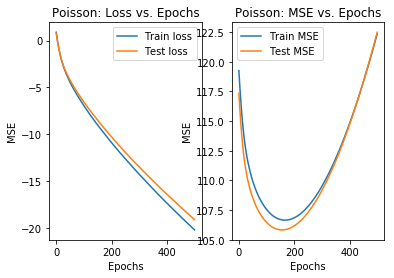

In [462]:
# plot loss and accuracies graphs

regr.plot_graph(train_losses, test_losses, train_mse_arr, test_mse_arr)

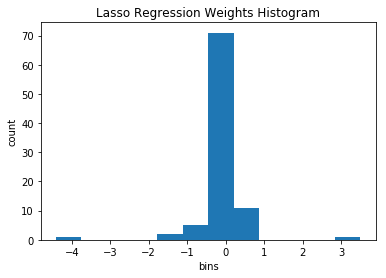

In [463]:
# plot the weights
regr.plot_weights()

In [464]:
test_preds[2050:2110]

array([[ -3.72606185],
       [ -6.14030572],
       [ -5.82944917],
       [ -2.95568921],
       [ -6.89330173],
       [ -6.8706404 ],
       [ -6.28919821],
       [ -1.70994999],
       [ -2.85672681],
       [-22.44216783],
       [  0.50697497],
       [ -2.66193985],
       [ -0.62060526],
       [ -8.91248448],
       [ -2.79876902],
       [ -2.52727487],
       [ -3.76870775],
       [ -3.48042063],
       [ -4.21772827],
       [ -2.09322842],
       [ -3.0315747 ],
       [ -3.21220148],
       [ -9.45713574],
       [ -3.24707102],
       [ -1.87185348],
       [ -3.03414263],
       [ -4.05499774],
       [ -1.03467248],
       [ -0.37951301],
       [ -1.45694014],
       [ -4.41609655],
       [-20.18059186],
       [ -5.13050564],
       [ -3.72264187],
       [-15.8542955 ],
       [ -6.09727862],
       [ -2.56863545],
       [ -5.49204598],
       [ -2.86193008],
       [ -4.50307792],
       [ -3.36787259],
       [ -7.12586482],
       [ -1.18037291],
       [ -7

In [466]:
y_test_sm[2050:2110]

array([[ -0.49592299],
       [ -0.49592299],
       [ -0.49592299],
       [ -0.49592299],
       [ -0.49592299],
       [ -0.49592299],
       [ -0.49592299],
       [ -0.49592299],
       [ -0.49592299],
       [  0.50407701],
       [  0.50407701],
       [  0.50407701],
       [  0.50407701],
       [  0.50407701],
       [  0.50407701],
       [  0.50407701],
       [  0.50407701],
       [  0.50407701],
       [  0.50407701],
       [  0.50407701],
       [  0.50407701],
       [ 10.50407701],
       [ 10.50407701],
       [ 10.50407701],
       [ 10.50407701],
       [ 10.50407701],
       [ 10.50407701],
       [ 10.50407701],
       [ 10.50407701],
       [ 10.50407701],
       [  9.50407701],
       [  9.50407701],
       [  9.50407701],
       [  9.50407701],
       [  9.50407701],
       [  9.50407701],
       [  9.50407701],
       [  9.50407701],
       [  9.50407701],
       [  9.50407701],
       [  9.50407701],
       [  9.50407701],
       [  9.50407701],
       [  6